## 1. Załadowanie danych i bibliotek

In [77]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import metrics
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [20]:
data = pd.read_csv("australia.csv")
data.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0


In [21]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333,0.220879,0.220259
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543,0.414843,0.414425
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000,0.000000,0.000000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000,0.000000,0.000000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000,0.000000,0.000000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000,0.000000,0.000000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000,1.000000,1.000000


## 2. Podział danych na zbiór treningowy i testowy
Dane podzielimy tak, aby stosunek labeli celu był taki sam co w całym zbiorze. Nie musimy nic encodować, poneważ zmienne nie są kategoryczne.

In [22]:
target = "RainTomorrow"

X_train, X_test, Y_train, Y_test = train_test_split(
    data.drop(target, axis = 1),
    data[target],
    stratify = data[target])

#train dataframe
dtrain = pd.concat([X_train,Y_train], axis=1)

#test dataframe
dtest = pd.concat([X_test,Y_test], axis=1)

predictors = [x for x in dtrain.columns if x not in [target]]

## 3. Random Forest

Zaczniemy od modelu z użyciem klasfykiatora Random Forest. SKorzystamy z funkcji GridSearchCV, tak aby znaleźc optymalne wartości parametrów:
- n_estiamtors - ilsoc drzew 
- max_features - ilosc featerow do uwzglednienia przy rozglaezeiniach drzew 
- max_depth - maksymalna wysokosc drzew
- criterion - funkcja do mierzenia jakosci podzialu w drzewie

In [24]:
rf_model = Pipeline([
  ('classifier', RandomForestClassifier())
])


param_grid = { 
    'classifier__n_estimators': [50, 100],# the number of trees in the forest.
    'classifier__max_features': ['sqrt', 'log2'], # the number of features to consider when looking for the 
                                                  # best split:
                                                      ## if “sqrt”, then max_features=sqrt(n_features)
                                                      ## if “log2”, then max_features=log2(n_features).
    
    'classifier__max_depth' : [6,8],
    'classifier__criterion' :['gini', 'entropy'] # the function to measure the quality of a split. 
                                                 # Supported criteria are “gini” for the Gini impurity 
                                                 # and “entropy” for the information gain
}

rf_grid_search = GridSearchCV(rf_model, param_grid = param_grid, cv = 5)
rf_grid_search.fit(X_train, Y_train)
rf_grid_search.best_params_

In [49]:
rf_model = rf_grid_search.best_estimator_
rf_predict_class = rf_model.predict(X_test)
rf_predict_proba = rf_model.predict_proba(X_test)[:, 1]

array([0.44015923, 0.21124032, 0.03108652, ..., 0.37956874, 0.02806886,
       0.11249485])

 ## 4. XGBoost
 
Kolejnym klasfykiatorem jakim użyjemy będzie XGBoost. Tutaj zmniejszymy parametr learning rate. XGBoost tworzy i dodaje do modelu drzewa po kolei, nowe drzewa są tworzone, aby poprawić błędy z predykcji na podstawie poprzednich drzew. Prowadzi to do tego, ze model może szybko stać sie modelem overfitujacym. Aby temu zapobiec mozemy zmniejszyć wagę "popraw" w danym drzewie, odpowiada za to parametr learning_rate, im mniejszy on jest tym mniejsze poprawki wprowadza jedno drzewo, ergo drzew jest dużo więcej. Po zmniejszeniu learning_rate musimy znaleźć odpowiednią ilość drzew (n_estiamtors) tak, aby tych drzew nei było za dużo.

Skorzystamy w tym przypadku z funkcji, która jeżeli przy dodaniu kolejnych 50 drzew algorytm nie daje lepszych wyników, to wtedy zmienai wartość parametru n_estiamtors na tę optymalną ilość.

In [50]:
# Function which finds the optimum number of trees (n_estimators parameter) using cv function of xgboost
# for given learning_rate and changes the alg parameter accrodingly
def modelfit(alg, dtrain, predictors, cv_folds = 5, early_stopping_rounds = 50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label = dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'],
                      nfold=cv_folds, metrics='auc', early_stopping_rounds = early_stopping_rounds)
    alg.set_params(n_estimators = cvresult.shape[0])

In [53]:
# Our default calssifier, whose parameters will be tuned in grid_search_cv
xgb1 = xgb.XGBClassifier(
 learning_rate = 0.01,
 n_estimators = 5000,
 max_depth = 5,
 min_child_weight = 1,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

# Let's assume fixed learning_rate = 0.01 and find optimum n_estiamtors parameter value for it
modelfit(xgb1, dtrain, predictors)

In [61]:
xgb_model = Pipeline([
  ('classifier', xgb1)
])

xgb_model.fit(X_train,Y_train)

xgb_predict_class = xgb_model.predict(X_test)
xgb_predict_proba = xgb_model.predict_proba(X_test)[:, 1]


## 5. Logistic Regression

Na koniec zajmiemy się regresją liniową. Tu również skorzystamy z funkcji GridSearchCV, tak aby znaleźc optymalne wartości parametrów:
- C - odpowiada za regularyzacje (im wieksza wartosc parametru tym mniej silna regualryzacja)
- penalty - wybór typu regualryzacji  L1 - Lasso Regression, L2 - Ridge Regression.
- class_weight - nadanie wag klasom targetu

In [67]:
lr_model = Pipeline([
    ('estimator',LogisticRegression(max_iter=200,random_state=123,
                                   multi_class='ovr',solver='saga'))
])


# Grid params search 
param_grid = {'estimator__C': np.logspace(-4, 4, 20),#Inverse of regularization strength
              'estimator__penalty':['l2','l1'],# Type of loss function 
              'estimator__class_weight':['balanced',None]# Type of class weight 
                                                    # None - Every class have weight 1 
                                                    # Auto Class weight calcultion
              
      }

# Preparing and fitting grid search 
lr_grid_search = GridSearchCV(lr_model, param_grid = param_grid, cv = 5)
lr_grid_search.fit(X_train,Y_train)
lr_grid_search.best_params_

{'estimator__C': 0.00026366508987303583,
 'estimator__class_weight': None,
 'estimator__penalty': 'l2'}

In [68]:
lr_model = lr_grid_search.best_estimator_
lr_predict_class = lr_model.predict(X_test)
lr_predict_proba = lr_model.predict_proba(X_test)[:, 1]

## 6. Porównanie wyników

In [72]:
pd.DataFrame({"Encoder" : ["Random Forest", "XGBoost", "Logistic Regression"],
             "Precision": [precision_score(Y_test, rf_predict_class, average='macro'), precision_score(Y_test, xgb_predict_class, average='macro'), precision_score(Y_test, lr_predict_class, average='macro')],
             "Recall": [recall_score(Y_test, rf_predict_class), recall_score(Y_test, xgb_predict_class),recall_score(Y_test, lr_predict_class)]})

,Encoder,Precision,Recall
0,Random Forest,0.813764,0.476344
1,XGBoost,0.819785,0.550692
2,Logistic Regression,0.799425,0.519150


In [75]:
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(Y_test, rf_predict_proba)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(Y_test, xgb_predict_proba)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_test, lr_predict_proba)

pd.DataFrame({"Encoder" : ["Random Forest", "XGBoost", "Logistic Regression"],
             "AUC": [metrics.auc(fpr_rf, tpr_rf), metrics.auc(fpr_xgb, tpr_xgb), metrics.auc(fpr_lr, tpr_lr
                                                                                            )]})

,Encoder,AUC
0,Random Forest,0.885618
1,XGBoost,0.899775
2,Logistic Regression,0.880090


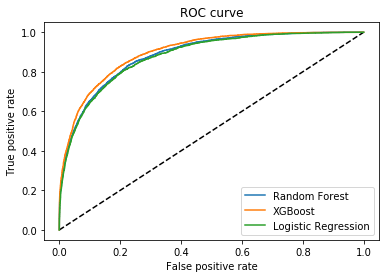

In [79]:
# ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Jak widzimy najlepiej spisał się XGBoost mimo tego, że jego hiperparametry prawie w ogóle nie było dostrajane. Różnice między poszczególnymi algorytmami są niewielkie. Myślę, że biorąc i strojąc większą ilosć parametrów wydajność wszystkich 3 algorytmów mogłaby wzrosnąć i róznice mogłby by się neico zmienić.